# Exploratory Data Analysis for Final Project

In this assignment, your task is to put your new skils to use in the form of an open-ended, exploratory data analysis. In particular, I'm looking for you to demonstrate your ability to use the programmatic tools we've been learning to access data, manipulate it, and visualize some findings while working towards the ultimate goal of developing a final project proposal. Please include the following in your assignment:

  1. A brief summary of the topic (a few sentences)
  2. Access 2 or more datasets, at least one of them using an API (if you are not using any data from an API as part of your project yet, don’t worry about it, and just do this to get some exercise using APIs. You might use it later).
  3. Demonstrate the use of Pandas operations to filter out missing data and/or outliers.
  4. Demonstrate your capacity to use some of the "group-by" operations to produce pivot tables or statistical summaries of your data.
  5. Use Matplotlib or Seaborn to produce 2-3 data visualizations of your data to both explore the data and highlight any notable patterns.
  6. Include a short written analysis of your interpretation of the data.
  7. In a few paragraphs, describe the research question you intend to investigate in your final project, and the plan for the data analysis you intend to perform.

Note that this exercise is intended to help you formulate your project topic. But it is not a binding contract. Your project will most likely evolve over the rest of the semester. So use this as an opportunity to be creative, throw some ideas against the wall and see what sticks. I will release the final project guidelines shortly. In the meantime, dig in!

And as always, please submit this assignment both as a PR on GitHub along with the URL of your PR on bCourses.

# Final Project: Electric Vehicles

For my final project, I plan to look at the data from the State of Washington to study electric vehicle adoption. I will look at data on the registration of EVs, as well as the locations of EV chargers, to see if EVs are more concentrated in areas with more charging infrastructure. I will also use data from the Climate and Economic Justice Screening Tool to compare the areas with their demographic data. I also brought in data on evictions to see if there is a pattern with counties that see more evictions versus those places with high EV concentrations. 

In [1]:
## Import Packages
import pandas as pd
import json    
import requests  
import pprint    
import seaborn as sns
from matplotlib import pyplot as plt
import csv

In [8]:
endpoint_url = "https://data.wa.gov/resource/f6w7-q2d2.json"
evs = pd.read_json(endpoint_url)
len(evs) # This only gives 1000 rows, due to API limit. i will use downloaded data instead to access all data but kept as an example of API access

1000

In [19]:
# Import data
cejst = pd.read_csv('data/CEJST.csv', low_memory = False)
evictions = pd.read_csv('data/evictions.csv', low_memory = False)
evs = pd.read_csv('data/ev_wa.csv', low_memory = False)
charging_stations = pd.read_csv('data/charging_stations_WA.csv', low_memory = False) ## should I filter for PUBLIC stations

In [10]:
evs_clean = evs.dropna() # does this remove every row that has any NAs? Not what i want 
evs_clean.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5UXKT0C59G,Yakima,Zillah,WA,98953.0,2016,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14.0,0.0,15.0,206822717,POINT (-120.26317 46.40556),PACIFICORP,5.307700e+10
1,5YJ3E1EA2J,Snohomish,Edmonds,WA,98020.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,21.0,137721636,POINT (-122.37507 47.80807),PUGET SOUND ENERGY INC,5.306105e+10
2,1G1RE6E4XE,Kitsap,Port Orchard,WA,98367.0,2014,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,38.0,0.0,26.0,197718468,POINT (-122.6847073 47.50524),PUGET SOUND ENERGY INC,5.303509e+10
3,2C4RC1L76M,Skagit,Bow,WA,98232.0,2021,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,32.0,0.0,40.0,256274308,POINT (-122.440636 48.5613885),PUGET SOUND ENERGY INC,5.305795e+10
4,5YJ3E1EA2J,Thurston,Olympia,WA,98513.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,2.0,259176578,POINT (-122.817545 46.98876),PUGET SOUND ENERGY INC,5.306701e+10


In [60]:
# I want to know how many EVs are in each county 
evs_clean['County FIPS'] = evs_clean['2020 Census Tract'].astype(str).str[:5]
county_evs = evs_clean.groupby('County FIPS').size()
county_evs = county_evs.to_frame().reset_index()
county_evs = county_evs.rename(columns={0: 'Count'})
county_evs.head()

,County FIPS,Count
0,53001,47
1,53003,69
2,53005,2108
3,53007,1025
4,53009,1035


In [38]:
evictions_wa = evictions[evictions['fips_state'] == 53].copy()
evictions_compiled = evictions_wa[['fips_county', 'renting_hh', 'filings_observed']].groupby('fips_county').sum().copy()
evictions_compiled.head()

,renting_hh,filings_observed
fips_county,,
53001,30296,174
53003,42940,664
53005,319418,7619
53007,153262,1650
53009,134105,1795


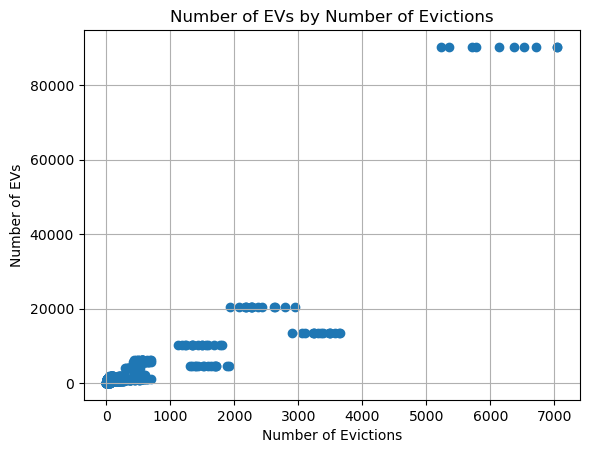

In [65]:
evictions_wa = evictions_wa.rename(columns={'fips_county': 'County FIPS'})
evictions_wa['County FIPS'] = evictions_wa['County FIPS'].astype(str)
county_evs['County FIPS'] = county_evs['County FIPS'].astype(str)

evictions_evs = pd.merge(county_evs, evictions_wa, on='County FIPS', how='left')


plt.scatter(evictions_evs['filings_observed'], evictions_evs['Count']) ## do i need to make these divided by the number of households? to account for differences in density? 
plt.title('Number of EVs by Number of Evictions')
plt.xlabel('Number of Evictions')
plt.ylabel('Number of EVs')
plt.grid(True)
plt.show()

This graph is meant to show the relationship between number of EVs and number of eviction filings in each county. I don't know if it is "accurate" at this point, as I may need to account for differences in density of counties. The data generally is a bit wonky, and this graph doesn't seem that easy to read at this point. Room for improvement. 

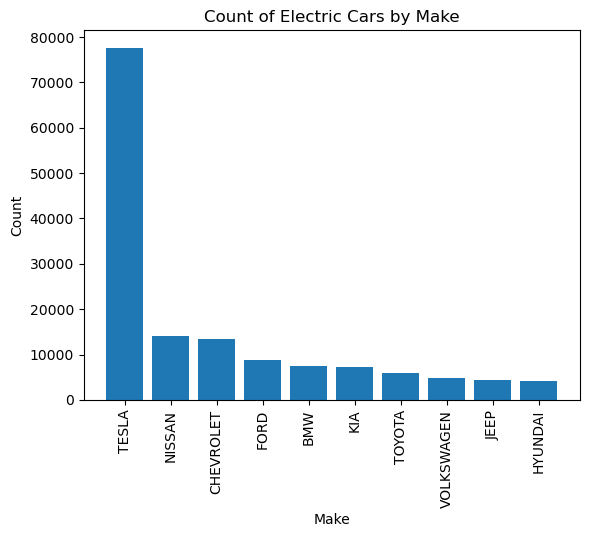

In [66]:
# Let's examine the most common type of EV to own! 
evs_counts = pd.DataFrame(evs_clean['Make'].value_counts())
evs_counts.columns = ['Count']
top_evs = evs_counts.head(10)


plt.bar(top_evs.index, top_evs['Count'])
plt.title('Count of Electric Cars by Make')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

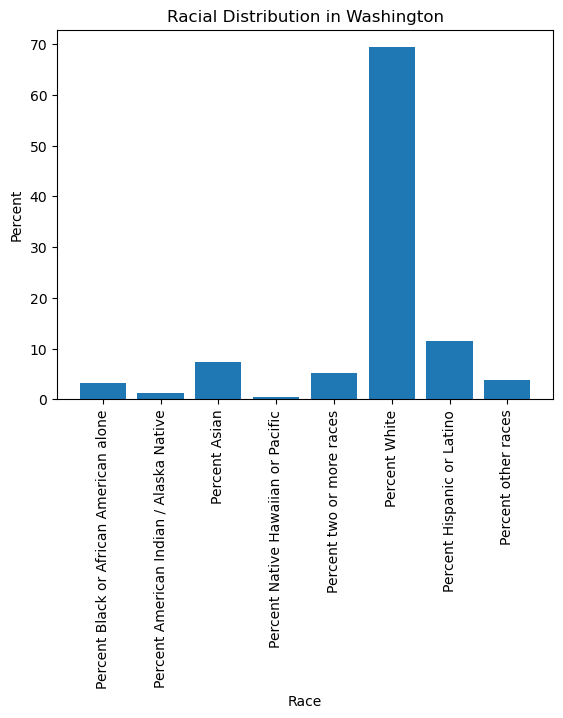

In [67]:
# Now I'll look at the racial demographics of Washington
cejst_wa = cejst[cejst['State/Territory'] == "Washington"].copy()
cejst_wa_races = cejst_wa[['Percent Black or African American alone', 'Percent American Indian / Alaska Native', 'Percent Asian', 'Percent Native Hawaiian or Pacific', 'Percent two or more races', 'Percent White', 'Percent Hispanic or Latino', 'Percent other races']]
cejst_wa_races_avg = cejst_wa_races.mean() * 100

plt.bar(cejst_wa_races_avg.index, cejst_wa_races_avg.values)
plt.title('Racial Distribution in Washington')
plt.xlabel('Race')
plt.ylabel('Percent')
plt.xticks(rotation = 90)
plt.show()
## How to sort by biggest to smallest? 

From the graphs above, we can Washington has a large majority of White residents, and most EVs are Teslas. Now, let's see if the evictions data will be useful in seeing 

## Write up

My research question is: Are EVs more concentrated in places with better EV infrastructure? What about in places of higher wealth? Are there other demographic patterns that help show where EVs are highly concentrated? Is there a realtionship between places that see more evictions and places that see more EV registrations? 

I need to map the EV charging locations to the census block group or county to be able to compare the density of chargers with the density of EVs. Some of my analysis will need to be geographical, so I will need to get more familiar with the GIS packages to achieve this. I will map the density of EV chargers to EVs registered, and will need to calculate this density based on either land area or population. I also need to consider if I am going to include all EV chargers, or only public ones. 

I also want to look into using the seaborn package to make better looking graphs than what I've produced so far. 

I wonder if there is potential to run a regression in this project to see how much these demographic and charging infrastructure variables impact the concentration of EVs, or even if there is a machine learning approach that would make a model that could predict how adding charging infrastructure would impact the density of EVs in that area. I would need to find historic data on EVs, and know the years the chargers were build, and ALSO be able to control for other things that would impact EV adoption (like tax benefits, gas prices, etc.) which actually seems really hard. So maybe just a regression for this project? Or a correlation test! 